# Predicing Titanic Survival using Logistic Regression

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

## Import Libraries
Let's import some libraries to get started!

In [24]:
import numpy as np                    # linear algebra
import pandas as pd                   # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Get Data
Let's start by reading in the train.csv file into a pandas dataframe.

In [25]:
train = pd.read_csv("dataset/train.csv")
test_data = pd.read_csv("dataset/test.csv") 

In [26]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

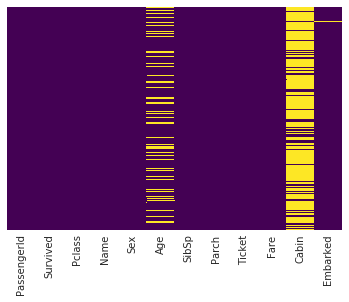

In [27]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data!

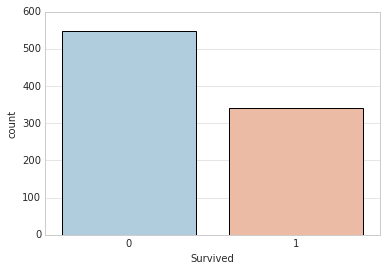

In [28]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

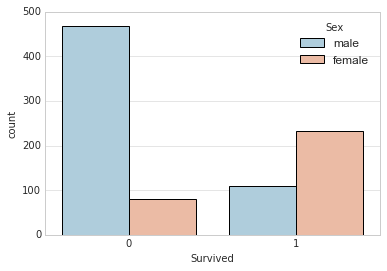

In [29]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

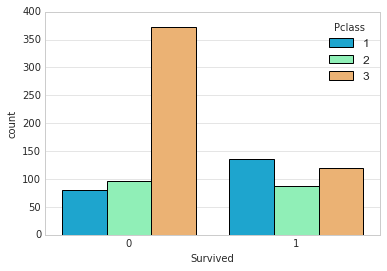

In [31]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

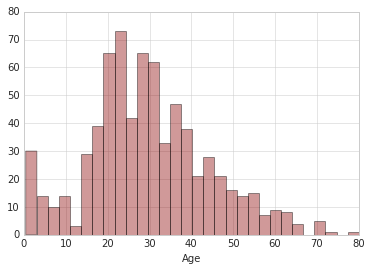

In [32]:
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

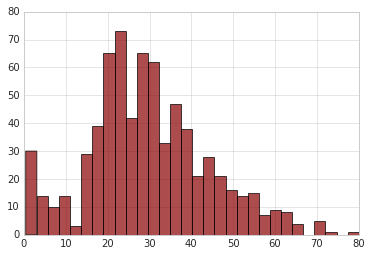

In [33]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

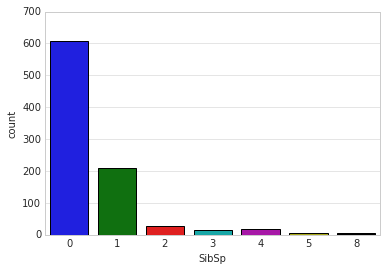

In [34]:
sns.countplot(x='SibSp',data=train)

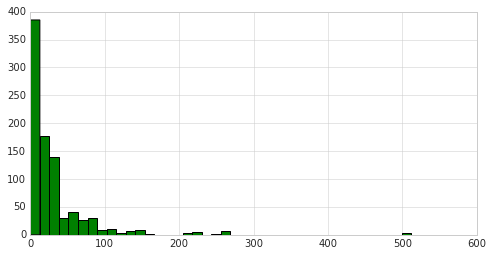

In [35]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:

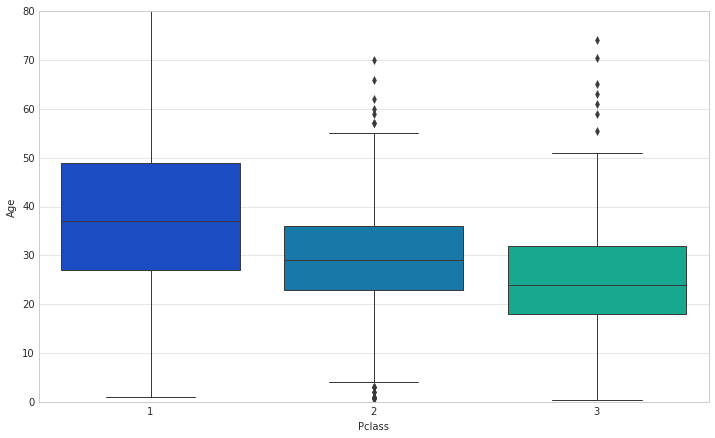

In [37]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [38]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

Now apply that function!

In [40]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)
test_data['Age'] = test_data[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

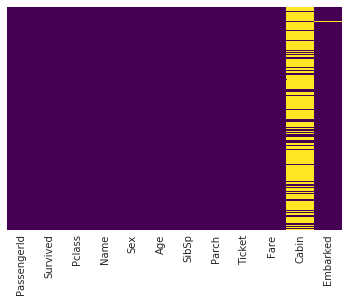

In [41]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [42]:
train.drop('Cabin',axis=1,inplace=True)
test_data.drop('Cabin',axis=1,inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [43]:
#for train data
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
train = pd.concat([train,sex,embark],axis=1)




In [44]:
#for test data
test_sex = pd.get_dummies(test_data['Sex'],drop_first=True)
test_embark = pd.get_dummies(test_data['Embarked'],drop_first=True)
test_data.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
test_data = pd.concat([test_data,test_sex,test_embark],axis=1)


In [45]:
#fill null value of fare column with 0
test_data.Fare.fillna(0 ,inplace = True)

Great! Our data is ready for our model!

## Lets build the Logistic Regression model

Let's start by splitting our data into a training set and test set

## Train Test Split

In [46]:
#Train Test Split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Survived','PassengerId'],axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting¶

In [47]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
predictions = logmodel.predict(X_test)

Let's move on to evaluate our model!

## Evaluation


We can check precision,recall,f1-score using classification report!

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.77      0.86      0.81       154
          1       0.78      0.65      0.71       114

avg / total       0.77      0.77      0.77       268



In [53]:
id = test_data['PassengerId']
predictions = logmodel.predict(test_data.drop('PassengerId', axis=1))
result = pd.DataFrame({ 'PassengerId' : id, 'Survived': predictions })
result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [54]:
#writing the output in csv 
result.to_csv('output/titanic-predictions.csv', index = False)

Not so bad! We can explore other feature engineering, some suggestions for feature engineering:

* Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
* Maybe the Cabin letter could be a feature
* Is there any info you can get from the ticket?

## Great Job!